In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import re
import string
import nltk
from nltk import word_tokenize, PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('drive/MyDrive/reviews/reviews_train.csv')
print(len(data))
data.head()

555791


,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime,score
0,A35C43YE9HU9CN,B0064X7B4A,Joan Miller,"[0, 0]",I have decided not to play this game. I can't...,Friends,1396396800,"04 2, 2014",1.0
1,AHFS8CGWWXB5B,B00H1P4V3E,WASH ST. GAMER,"[3, 4]",The Amazon Appstore free app of the day for Ju...,"Amazon Makes This ""Longest Spring Ever"" for Fi...",1402272000,"06 9, 2014",2.0
2,A3EW8OTQ90NVHM,B00CLVW82O,Kindle Customer,"[0, 4]",this game was so mush fun I wish I could play ...,best,1368921600,"05 19, 2013",5.0
3,AJ3GHFJY1IUTD,B007T9WVKM,BrawlMaster4,"[0, 2]","Its pretty fun and very good looking, but you...",Fun Game,1350172800,"10 14, 2012",5.0
4,A3JJGBS4EL603S,B00J206J5E,"K. Wilson ""thesupe""","[0, 0]",good graphics; immersive storyline; hard to st...,great game!,1396915200,"04 8, 2014",5.0


In [ ]:
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      14
helpful            0
reviewText         8
summary           24
unixReviewTime     0
reviewTime         0
score              0
dtype: int64

In [4]:
data = data.dropna()
len(data)

555745

In [5]:
data['score']=data['score'].astype(int)

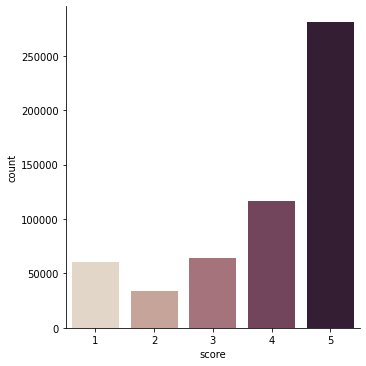

In [ ]:
sns.catplot(x="score", kind="count", palette="ch:.25", data=data).savefig('drive/MyDrive/reviews/distribution.png')

In [6]:
data['helpful_yes'] = data['helpful'].apply(lambda x: eval(x)[0])
data['helpful_not'] = data['helpful'].apply(lambda x: eval(x)[1]) 

data['helpfulness'] = np.where(data['helpful_not'] > 0, data['helpful_yes'] / (data['helpful_not']), 1.0)

In [ ]:
data['helpfulness'].describe()
# data.sample(10)

count    555745.000000
mean          0.867519
std           0.281324
min           0.000000
25%           0.966667
50%           1.000000
75%           1.000000
max           1.000000
Name: helpfulness, dtype: float64

In [ ]:
data=data.drop(columns=['helpful_yes', 'helpful_not'])

In [ ]:
data[['helpfulness', 'score']].corr(method='spearman')

,helpfulness,score
helpfulness,1.000000,0.232083
score,0.232083,1.000000


In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess_text(text):
  text = text.lower()
  text = text.strip()
  text = re.sub('\s\s+', ' ', text)
  text = ''.join([char for char in text if char not in string.punctuation])
  text = [stemmer.stem(word) for word in word_tokenize(text) if word not in stop_words]
  return text

In [10]:
data['review_and_summary_preprocessed'] = data['reviewText'] + ' ' + data['summary']
data['review_and_summary_preprocessed'] = data['review_and_summary_preprocessed'].apply(preprocess_text)
data[['review_and_summary_preprocessed']].head()

,review_and_summary_preprocessed
0,"[decid, play, game, cant, keep, track, everyon..."
1,"[amazon, appstor, free, app, day, june, 9th, 2..."
2,"[game, mush, fun, wish, could, play, love, pay..."
3,"[pretti, fun, good, look, drive, like, 300, mp..."
4,"[good, graphic, immers, storylin, hard, stop, ..."


In [11]:
train_df, test_df = train_test_split(data, stratify=data['score'], test_size=0.2)
train_df.to_csv('drive/MyDrive/reviews/train.csv')
test_df.to_csv('drive/MyDrive/reviews/test.csv')
test_df_raw = test_df.drop(columns=['helpfulness', 'review_and_summary_preprocessed'])
test_df_raw.to_csv('drive/MyDrive/reviews/test_raw.csv', index=False)

In [12]:
tfidf = TfidfVectorizer(analyzer='word', stop_words='english', min_df=5, ngram_range=(1,2), max_features=24000)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_df[['review_and_summary_preprocessed', 'helpfulness']], train_df['score'], test_size=0.1, stratify=train_df['score'])

In [ ]:
X_train['helpfulness'].describe()

count    400136.000000
mean          0.867644
std           0.281033
min           0.000000
25%           0.962963
50%           1.000000
75%           1.000000
max           1.000000
Name: helpfulness, dtype: float64

In [15]:
list_of_docs_train = [' '.join(words) for words in X_train['review_and_summary_preprocessed'].tolist()]
list_of_docs_val = [' '.join(words) for words in X_val['review_and_summary_preprocessed'].tolist()]

tfidf.fit(list_of_docs_train)

X_train_tfidf = tfidf.transform(list_of_docs_train)
X_val_tfidf = tfidf.transform(list_of_docs_val)
X_train_tfidf.shape

(400136, 24000)

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_tfidf, y_train)
y_pred = dummy_clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4811
           2       0.00      0.00      0.00      2699
           3       0.00      0.00      0.00      5111
           4       0.00      0.00      0.00      9323
           5       0.51      1.00      0.67     22516

    accuracy                           0.51     44460
   macro avg       0.10      0.20      0.13     44460
weighted avg       0.26      0.51      0.34     44460



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_tfidf, y_train)
y_pred = dummy_clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.11      0.11      0.11      4811
           2       0.06      0.06      0.06      2699
           3       0.11      0.11      0.11      5111
           4       0.21      0.21      0.21      9323
           5       0.51      0.51      0.51     22516

    accuracy                           0.33     44460
   macro avg       0.20      0.20      0.20     44460
weighted avg       0.33      0.33      0.33     44460



In [ ]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train_tfidf, y_train)
y_pred = dummy_clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.11      0.20      0.14      4811
           2       0.07      0.21      0.10      2699
           3       0.12      0.20      0.15      5111
           4       0.21      0.20      0.20      9323
           5       0.51      0.20      0.29     22516

    accuracy                           0.20     44460
   macro avg       0.20      0.20      0.18     44460
weighted avg       0.33      0.20      0.23     44460



In [ ]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_tfidf, y_train)
y_pred_tree = tree_clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred_tree))

              precision    recall  f1-score   support

           1       0.49      0.50      0.50      4811
           2       0.17      0.14      0.15      2699
           3       0.30      0.28      0.29      5111
           4       0.31      0.30      0.31      9323
           5       0.69      0.72      0.70     22516

    accuracy                           0.52     44460
   macro avg       0.39      0.39      0.39     44460
weighted avg       0.51      0.52      0.52     44460



In [ ]:
svd = TruncatedSVD(n_components=750)
X_train_tfidf_pca = svd.fit_transform(X_train_tfidf)
X_val_tfidf_pca = svd.transform(X_val_tfidf)
print(X_train_tfidf_pca.shape)
print(sum(svd.explained_variance_ratio_))

(400136, 750)
0.38610525128398215


In [ ]:
tree_clf2 = DecisionTreeClassifier()
tree_clf2.fit(X_train_tfidf_pca, y_train)
y_pred_tree2 = tree_clf2.predict(X_val_tfidf_pca)
print(classification_report(y_val, y_pred_tree2))

              precision    recall  f1-score   support

           1       0.36      0.35      0.35      4811
           2       0.13      0.13      0.13      2699
           3       0.23      0.23      0.23      5111
           4       0.27      0.27      0.27      9323
           5       0.65      0.64      0.65     22516

    accuracy                           0.46     44460
   macro avg       0.33      0.33      0.33     44460
weighted avg       0.46      0.46      0.46     44460



In [ ]:
undersampler = RandomUnderSampler()
X_train_tfidf_pca_res, y_train_res = undersampler.fit_resample(X_train_tfidf_pca, y_train)
print(Counter(y_train_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({1: 24289, 2: 24289, 3: 24289, 4: 24289, 5: 24289})


In [ ]:
tree_clf3 = DecisionTreeClassifier()
tree_clf3.fit(X_train_tfidf_pca_res, y_train_res)
y_pred_tree3 = tree_clf3.predict(X_val_tfidf_pca)
print(classification_report(y_val, y_pred_tree3))

              precision    recall  f1-score   support

           1       0.29      0.39      0.33      4811
           2       0.10      0.27      0.15      2699
           3       0.17      0.27      0.21      5111
           4       0.26      0.29      0.28      9323
           5       0.71      0.40      0.51     22516

    accuracy                           0.35     44460
   macro avg       0.31      0.32      0.30     44460
weighted avg       0.47      0.35      0.39     44460



In [ ]:
undersampler = RandomUnderSampler(random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
print(type(X_train_res[0]))
print(X_train_res[:,0])
X_train_tfidf_res = tfidf.transform([' '.join(words) for words in X_train_res[:, 0]])

# X_train_tfidf_res, y_train_res = undersampler.fit_resample(X_train_tfidf, y_train)
print(Counter(y_train_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<class 'numpy.ndarray'>
[list(['think', 'app', 'tri', 'rude', 'tutori', 'confusingi', 'tri', 'play', 'app', 'wow', 'blew', 'mind', 'stupid', 'game'])
 list(['realli', 'maker', 'app', 'realli', 'think', 'get', 'away', 'copi', 'fruit', 'ninaj', 'dont', 'get', 'app', 'suppos', 'su', 'tri', 'copi', 'fruit', 'ninja'])
 list(['app', 'joke', 'obvious', 'realiz', 'would', 'good', 'true', 'oh', 'well', 'worth', 'shot', 'poor'])
 ...
 list(['omg', 'love', 'app', 'much', 'use', 'onlin', 'want', 'see', 'app', 'stoke', 'amz', 'must', 'get', 'addict'])
 list(['love', 'angri', 'bird', 'game', 'much', 'ten', 'year', 'old', 'son', 'game', 'differ', 'hope', 'enjoy', 'angri', 'bird', 'finat'])
 list(['fun', 'playgreat', 'graphicsrememb', 'old', 'comput', 'gamethi', 'way', 'bettergood', 'joblov', 'itwish', 'time', 'playfun', 'good', 'time', 'great', 'game'])]
Counter({1: 24289, 2: 24289, 3: 24289, 4: 24289, 5: 24289})


In [ ]:
tree_clf4 = DecisionTreeClassifier()
tree_clf4.fit(X_train_tfidf_res, y_train_res)
y_pred_tree4 = tree_clf4.predict(X_val_tfidf)
print(classification_report(y_val, y_pred_tree4))

              precision    recall  f1-score   support

           1       0.41      0.48      0.44      4811
           2       0.14      0.31      0.19      2699
           3       0.23      0.32      0.26      5111
           4       0.30      0.35      0.32      9323
           5       0.75      0.49      0.59     22516

    accuracy                           0.43     44460
   macro avg       0.36      0.39      0.36     44460
weighted avg       0.52      0.43      0.46     44460



In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 50, 100]
print('TFIDF IMBALANCED')
for alpha in alphas:
  print(f'alpha={alpha}')
  nb_clf = MultinomialNB(alpha=alpha)
  nb_clf.fit(X_train_tfidf, y_train)
  print(classification_report(y_val, nb_clf.predict(X_val_tfidf)))

print('TFIDF UNDERSAMPLED')
for alpha in alphas:
  print(f'alpha={alpha}')
  nb_clf = MultinomialNB(alpha=alpha)
  nb_clf.fit(X_train_tfidf_res, y_train_res)
  print(classification_report(y_val, nb_clf.predict(X_val_tfidf)))

TFIDF IMBALANCED
alpha=0.001
              precision    recall  f1-score   support

           1       0.61      0.66      0.63      4811
           2       0.36      0.08      0.13      2699
           3       0.46      0.27      0.34      5111
           4       0.47      0.25      0.33      9323
           5       0.68      0.92      0.78     22516

    accuracy                           0.63     44460
   macro avg       0.51      0.44      0.44     44460
weighted avg       0.58      0.63      0.58     44460

alpha=0.01
              precision    recall  f1-score   support

           1       0.61      0.66      0.63      4811
           2       0.36      0.08      0.13      2699
           3       0.46      0.27      0.34      5111
           4       0.47      0.25      0.33      9323
           5       0.68      0.92      0.78     22516

    accuracy                           0.63     44460
   macro avg       0.51      0.44      0.44     44460
weighted avg       0.58      0.63    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.73      0.43      0.54      4811
           2       0.00      0.00      0.00      2699
           3       0.58      0.06      0.12      5111
           4       0.39      0.07      0.12      9323
           5       0.57      0.99      0.72     22516

    accuracy                           0.57     44460
   macro avg       0.46      0.31      0.30     44460
weighted avg       0.52      0.57      0.46     44460

alpha=20


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.83      0.20      0.32      4811
           2       0.00      0.00      0.00      2699
           3       0.69      0.02      0.04      5111
           4       0.45      0.01      0.03      9323
           5       0.53      1.00      0.69     22516

    accuracy                           0.53     44460
   macro avg       0.50      0.25      0.22     44460
weighted avg       0.53      0.53      0.39     44460

alpha=30


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.89      0.10      0.18      4811
           2       0.00      0.00      0.00      2699
           3       0.79      0.01      0.02      5111
           4       0.57      0.00      0.01      9323
           5       0.51      1.00      0.68     22516

    accuracy                           0.52     44460
   macro avg       0.55      0.22      0.18     44460
weighted avg       0.57      0.52      0.37     44460

alpha=50


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.95      0.03      0.06      4811
           2       0.00      0.00      0.00      2699
           3       0.71      0.00      0.00      5111
           4       1.00      0.00      0.00      9323
           5       0.51      1.00      0.67     22516

    accuracy                           0.51     44460
   macro avg       0.63      0.21      0.15     44460
weighted avg       0.65      0.51      0.35     44460

alpha=100


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.90      0.00      0.00      4811
           2       0.00      0.00      0.00      2699
           3       1.00      0.00      0.00      5111
           4       0.00      0.00      0.00      9323
           5       0.51      1.00      0.67     22516

    accuracy                           0.51     44460
   macro avg       0.48      0.20      0.14     44460
weighted avg       0.47      0.51      0.34     44460

TFIDF UNDERSAMPLED
alpha=0.001
              precision    recall  f1-score   support

           1       0.53      0.62      0.57      4811
           2       0.22      0.41      0.29      2699
           3       0.33      0.37      0.35      5111
           4       0.37      0.45      0.40      9323
           5       0.82      0.61      0.70     22516

    accuracy                           0.54     44460
   macro avg       0.45      0.49      0.46     44460
weighted avg       0.60      0.54      0.56   

In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 50, 100]
print('TFIDF IMBALANCED')
for C in Cs:
  print(f'C={C}')
  lr_clf = LogisticRegression(C=C)
  lr_clf.fit(X_train_tfidf, y_train)
  print(classification_report(y_val, lr_clf.predict(X_val_tfidf)))

TFIDF IMBALANCED
C=0.001


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4811
           2       0.00      0.00      0.00      2699
           3       0.50      0.00      0.00      5111
           4       0.33      0.00      0.00      9323
           5       0.51      1.00      0.67     22516

    accuracy                           0.51     44460
   macro avg       0.27      0.20      0.13     44460
weighted avg       0.38      0.51      0.34     44460

C=0.01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      0.50      0.58      4811
           2       0.00      0.00      0.00      2699
           3       0.58      0.17      0.26      5111
           4       0.45      0.16      0.24      9323
           5       0.60      0.97      0.74     22516

    accuracy                           0.60     44460
   macro avg       0.46      0.36      0.36     44460
weighted avg       0.54      0.60      0.52     44460

C=0.1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.63      0.71      0.67      4811
           2       0.40      0.06      0.11      2699
           3       0.49      0.31      0.38      5111
           4       0.48      0.29      0.36      9323
           5       0.70      0.92      0.79     22516

    accuracy                           0.64     44460
   macro avg       0.54      0.46      0.46     44460
weighted avg       0.60      0.64      0.60     44460

C=1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.62      0.73      0.67      4811
           2       0.35      0.14      0.20      2699
           3       0.48      0.33      0.39      5111
           4       0.47      0.33      0.39      9323
           5       0.73      0.89      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.53      0.48      0.49     44460
weighted avg       0.61      0.64      0.61     44460

C=2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.64      0.71      0.67      4811
           2       0.35      0.19      0.24      2699
           3       0.46      0.35      0.40      5111
           4       0.46      0.34      0.39      9323
           5       0.74      0.88      0.80     22516

    accuracy                           0.65     44460
   macro avg       0.53      0.49      0.50     44460
weighted avg       0.61      0.65      0.62     44460

C=5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.62      0.73      0.67      4811
           2       0.35      0.14      0.20      2699
           3       0.43      0.39      0.41      5111
           4       0.47      0.32      0.38      9323
           5       0.74      0.88      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.52      0.49      0.49     44460
weighted avg       0.61      0.64      0.62     44460

C=10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.63      0.71      0.67      4811
           2       0.33      0.17      0.23      2699
           3       0.45      0.35      0.39      5111
           4       0.46      0.34      0.39      9323
           5       0.74      0.87      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.52      0.49      0.49     44460
weighted avg       0.61      0.64      0.62     44460

C=20


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.62      0.72      0.67      4811
           2       0.34      0.17      0.22      2699
           3       0.45      0.35      0.40      5111
           4       0.47      0.34      0.40      9323
           5       0.74      0.88      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.52      0.49      0.50     44460
weighted avg       0.61      0.64      0.62     44460

C=30


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.63      0.71      0.67      4811
           2       0.34      0.17      0.23      2699
           3       0.45      0.35      0.40      5111
           4       0.45      0.34      0.39      9323
           5       0.74      0.87      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.52      0.49      0.50     44460
weighted avg       0.61      0.64      0.62     44460

C=50


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.63      0.72      0.67      4811
           2       0.34      0.16      0.22      2699
           3       0.45      0.36      0.40      5111
           4       0.46      0.35      0.40      9323
           5       0.74      0.87      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.52      0.49      0.50     44460
weighted avg       0.61      0.64      0.62     44460

C=100
              precision    recall  f1-score   support

           1       0.65      0.69      0.67      4811
           2       0.35      0.17      0.23      2699
           3       0.44      0.37      0.40      5111
           4       0.46      0.33      0.38      9323
           5       0.73      0.88      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.53      0.49      0.50     44460
weighted avg       0.61      0.64      0.62     44460



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
for C in Cs:
  print(f'C={C}')
  lr_clf = LogisticRegression(C=C, max_iter=200)
  lr_clf.fit(X_train_tfidf_res, y_train_res)
  print(classification_report(y_val, lr_clf.predict(X_val_tfidf)))

C=0.001
              precision    recall  f1-score   support

           1       0.38      0.73      0.50      4811
           2       0.21      0.27      0.24      2699
           3       0.45      0.28      0.34      5111
           4       0.39      0.46      0.42      9323
           5       0.80      0.62      0.70     22516

    accuracy                           0.54     44460
   macro avg       0.45      0.47      0.44     44460
weighted avg       0.59      0.54      0.55     44460

C=0.01
              precision    recall  f1-score   support

           1       0.46      0.69      0.55      4811
           2       0.22      0.37      0.28      2699
           3       0.42      0.32      0.36      5111
           4       0.39      0.48      0.43      9323
           5       0.81      0.63      0.71     22516

    accuracy                           0.55     44460
   macro avg       0.46      0.50      0.47     44460
weighted avg       0.60      0.55      0.57     44460

C=0.1
 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.60      0.65      0.62      4811
           2       0.24      0.41      0.31      2699
           3       0.37      0.40      0.38      5111
           4       0.39      0.48      0.43      9323
           5       0.83      0.65      0.73     22516

    accuracy                           0.57     44460
   macro avg       0.49      0.52      0.49     44460
weighted avg       0.62      0.57      0.59     44460

C=2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.60      0.63      0.62      4811
           2       0.24      0.41      0.30      2699
           3       0.35      0.40      0.38      5111
           4       0.38      0.46      0.42      9323
           5       0.82      0.64      0.72     22516

    accuracy                           0.56     44460
   macro avg       0.48      0.51      0.49     44460
weighted avg       0.62      0.56      0.58     44460

C=5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.59      0.63      0.61      4811
           2       0.23      0.38      0.29      2699
           3       0.34      0.39      0.36      5111
           4       0.36      0.46      0.40      9323
           5       0.82      0.62      0.71     22516

    accuracy                           0.55     44460
   macro avg       0.47      0.50      0.47     44460
weighted avg       0.61      0.55      0.57     44460

C=10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.59      0.62      0.61      4811
           2       0.23      0.40      0.29      2699
           3       0.35      0.40      0.37      5111
           4       0.37      0.45      0.41      9323
           5       0.82      0.63      0.71     22516

    accuracy                           0.55     44460
   macro avg       0.47      0.50      0.48     44460
weighted avg       0.61      0.55      0.57     44460

C=20


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.59      0.61      0.60      4811
           2       0.22      0.38      0.28      2699
           3       0.31      0.39      0.35      5111
           4       0.35      0.44      0.39      9323
           5       0.81      0.60      0.69     22516

    accuracy                           0.53     44460
   macro avg       0.46      0.49      0.46     44460
weighted avg       0.60      0.53      0.55     44460

C=30


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.58      0.61      0.60      4811
           2       0.22      0.38      0.28      2699
           3       0.31      0.38      0.34      5111
           4       0.35      0.43      0.39      9323
           5       0.81      0.61      0.70     22516

    accuracy                           0.53     44460
   macro avg       0.45      0.48      0.46     44460
weighted avg       0.60      0.53      0.55     44460

C=50


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.59      0.60      0.59      4811
           2       0.21      0.40      0.28      2699
           3       0.31      0.36      0.33      5111
           4       0.34      0.44      0.39      9323
           5       0.81      0.59      0.68     22516

    accuracy                           0.52     44460
   macro avg       0.45      0.48      0.45     44460
weighted avg       0.59      0.52      0.55     44460

C=100
              precision    recall  f1-score   support

           1       0.58      0.59      0.58      4811
           2       0.21      0.40      0.27      2699
           3       0.30      0.37      0.33      5111
           4       0.35      0.42      0.38      9323
           5       0.81      0.59      0.68     22516

    accuracy                           0.52     44460
   macro avg       0.45      0.48      0.45     44460
weighted avg       0.59      0.52      0.54     44460



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
lr_clf = LogisticRegression(C=2)
lr_clf.fit(X_train_tfidf, y_train)
y_pred_lr = lr_clf.predict(X_val_tfidf)
y_pred_lr_proba = lr_clf.predict_proba(X_val_tfidf)
print(classification_report(y_val, y_pred_lr))

              precision    recall  f1-score   support

           1       0.64      0.71      0.67      4811
           2       0.35      0.19      0.24      2699
           3       0.46      0.35      0.40      5111
           4       0.46      0.34      0.39      9323
           5       0.74      0.88      0.80     22516

    accuracy                           0.65     44460
   macro avg       0.53      0.49      0.50     44460
weighted avg       0.61      0.65      0.62     44460



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(y_pred_lr_proba[0:5])
print(X_val['helpfulness'].head())

[[5.76328611e-03 6.28562794e-03 2.00848864e-02 7.62069819e-02
  8.91659218e-01]
 [1.38807527e-02 4.91876125e-02 2.91482742e-01 5.49529641e-01
  9.59192521e-02]
 [2.67558025e-04 1.84600994e-03 2.92671028e-02 4.21734010e-01
  5.46885319e-01]
 [6.69266999e-03 3.90889799e-02 2.43025614e-01 4.64069290e-01
  2.47123446e-01]
 [1.02393832e-02 1.41531794e-02 2.89832988e-02 1.94785731e-01
  7.51838408e-01]]
292613    1.0
11271     1.0
251915    1.0
57340     0.5
457247    1.0
Name: helpfulness, dtype: float64


In [ ]:
X_proba_train = lr_clf.predict_proba(X_train_tfidf)
X_proba_val = lr_clf.predict_proba(X_val_tfidf)
X_proba_help_train = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_train, X_train['helpfulness'].tolist())]
X_proba_help_val = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_val, X_val['helpfulness'].tolist())]
print(X_proba_help_train[0])
print(X_proba_help_val[0])

[0.03513642 0.110353   0.19298189 0.35026011 0.31126857 0.7962963 ]
[0.00576329 0.00628563 0.02008489 0.07620698 0.89165922 1.        ]


In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_proba_help_train, y_train)
pred = tree.predict(X_proba_help_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           1       0.57      0.56      0.57      4811
           2       0.23      0.23      0.23      2699
           3       0.31      0.31      0.31      5111
           4       0.34      0.35      0.34      9323
           5       0.73      0.72      0.72     22516

    accuracy                           0.55     44460
   macro avg       0.44      0.43      0.43     44460
weighted avg       0.55      0.55      0.55     44460



In [ ]:
lr_clf2 = LogisticRegression(C=2)
lr_clf2.fit(X_proba_help_train, y_train)
pred = lr_clf2.predict(X_proba_help_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           1       0.66      0.70      0.68      4811
           2       0.35      0.19      0.24      2699
           3       0.44      0.38      0.41      5111
           4       0.45      0.36      0.40      9323
           5       0.75      0.87      0.80     22516

    accuracy                           0.64     44460
   macro avg       0.53      0.50      0.51     44460
weighted avg       0.62      0.64      0.63     44460



### Test dataset


In [40]:
X_test = test_df[['review_and_summary_preprocessed', 'helpfulness']]
X_train = train_df[['review_and_summary_preprocessed', 'helpfulness']]

list_of_docs_train = [' '.join(words) for words in X_train['review_and_summary_preprocessed'].tolist()]
list_of_docs_test = [' '.join(words) for words in X_test['review_and_summary_preprocessed'].tolist()]

X_train_tfidf = tfidf.fit_transform(list_of_docs_train)
X_test_tfidf = tfidf.transform(list_of_docs_test)

y_train = train_df['score']
y_test = test_df['score']

In [41]:
undersampler = RandomUnderSampler()
X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
list_of_docs_train_res = [' '.join(words) for words in X_train_res[:,0]]
X_train_tfidf_res = tfidf.transform(list_of_docs_train_res)
print(Counter(y_train_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({1: 26988, 2: 26988, 3: 26988, 4: 26988, 5: 26988})


In [42]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(444596, 24000)
(111149, 24000)


In [43]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_tfidf, y_train)
print(classification_report(y_test, dummy_clf.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           1       0.11      0.11      0.11     12028
           2       0.06      0.06      0.06      6747
           3       0.11      0.11      0.11     12778
           4       0.21      0.21      0.21     23307
           5       0.51      0.51      0.51     56289

    accuracy                           0.33    111149
   macro avg       0.20      0.20      0.20    111149
weighted avg       0.33      0.33      0.33    111149



In [44]:
lr_clf = LogisticRegression(C=2)
lr_clf.fit(X_train_tfidf, y_train)
y_pred = lr_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.63      0.72      0.67     12028
           2       0.34      0.14      0.20      6747
           3       0.48      0.37      0.42     12778
           4       0.47      0.33      0.39     23307
           5       0.73      0.89      0.80     56289

    accuracy                           0.65    111149
   macro avg       0.53      0.49      0.49    111149
weighted avg       0.61      0.65      0.62    111149



In [45]:
lr_clf_res = LogisticRegression(C=1)
lr_clf_res.fit(X_train_tfidf_res, y_train_res)
y_pred = lr_clf_res.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.62      0.64      0.63     12028
           2       0.25      0.44      0.32      6747
           3       0.38      0.43      0.41     12778
           4       0.40      0.48      0.44     23307
           5       0.83      0.66      0.73     56289

    accuracy                           0.58    111149
   macro avg       0.50      0.53      0.50    111149
weighted avg       0.63      0.58      0.60    111149



In [46]:
y_proba_train = lr_clf.predict_proba(X_train_tfidf)
y_proba_test = lr_clf.predict_proba(X_test_tfidf)

X_proba_help_train = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_train, X_train['helpfulness'].tolist())]
X_proba_help_test = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_test, X_test['helpfulness'].tolist())]

lr_clf_help = LogisticRegression(C=2)
lr_clf_help.fit(X_proba_help_train, y_train)
y_pred = lr_clf_help.predict(X_proba_help_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.70      0.67     12028
           2       0.35      0.17      0.23      6747
           3       0.45      0.42      0.43     12778
           4       0.47      0.35      0.40     23307
           5       0.75      0.87      0.81     56289

    accuracy                           0.65    111149
   macro avg       0.53      0.50      0.51    111149
weighted avg       0.62      0.65      0.63    111149



In [50]:
y_proba_train_res = lr_clf_res.predict_proba(X_train_tfidf_res)
y_proba_test = lr_clf_res.predict_proba(X_test_tfidf)

X_proba_help_train_res = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_train_res, X_train_res[:,1])]
X_proba_help_test = [np.append(probas, helpfulness) for (probas, helpfulness) in zip(y_proba_test, X_test['helpfulness'].tolist())]

lr_clf_help_res = LogisticRegression(C=1)
lr_clf_help_res.fit(X_proba_help_train_res, y_train_res)
y_pred = lr_clf_help.predict(X_proba_help_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.62      0.63     12028
           2       0.26      0.47      0.34      6747
           3       0.34      0.48      0.40     12778
           4       0.38      0.47      0.42     23307
           5       0.85      0.62      0.71     56289

    accuracy                           0.56    111149
   macro avg       0.50      0.53      0.50    111149
weighted avg       0.63      0.56      0.58    111149



In [52]:
nb_clf_res = MultinomialNB(alpha=5)
nb_clf_res.fit(X_train_tfidf_res, y_train_res)
y_pred = nb_clf_res.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.52      0.67      0.58     12028
           2       0.23      0.43      0.30      6747
           3       0.40      0.38      0.39     12778
           4       0.39      0.47      0.43     23307
           5       0.83      0.63      0.72     56289

    accuracy                           0.56    111149
   macro avg       0.47      0.52      0.48    111149
weighted avg       0.62      0.56      0.58    111149



In [ ]:
def prepare_data(data):
  data['review_and_summary_preprocessed'] = data['reviewText'] + ' ' + data['summary']
  data['review_and_summary_preprocessed'] = data['review_and_summary_preprocessed'].apply(preprocess_text)
  list_of_docs_test = [' '.join(words) for words in data['review_and_summary_preprocessed'].tolist()]
  X_test_tfidf = tfidf.transform(list_of_docs_test)
  return X_test_tfidf


In [55]:
import pickle
pickle.dump(lr_clf_res, open("lr_clf_res.pickle", "wb"))
pickle.dump(tfidf, open("tfidf.pickle", "wb"))


In [63]:
pickle.dump(preprocess_text, open('preprocess_text.pickle', 'wb'))

In [62]:
test_df_raw = test_df.drop(columns=['helpfulness', 'review_and_summary_preprocessed', 'helpful_yes', 'helpful_not'])
test_df_raw.to_csv('test_raw.csv', index=False)
test_df_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime,score
296696,A183BJURA8ULMO,B009UWM3OU,Wands Wade,"[2, 2]",This game is great it is so much fun trying to...,Guess the Word Premium,1359763200,"02 2, 2013",5
38880,A1FDLXNG7BIDAP,B006RAX9OQ,Glenn,"[1, 2]",You get 1 star until you remove the ads from m...,Update ruined the game.,1350604800,"10 19, 2012",1
413809,A1LIVZ6J2HE37Y,B008D2QRAO,rooster,"[0, 0]",this game is fun. the graphics are above avera...,slots journey,1343779200,"08 1, 2012",4
524340,A23GI2S7MVJRVP,B00G5LQ5MU,ace.mom,"[0, 0]",If you like puzzles you will enjoy this game. ...,clues,1388966400,"01 6, 2014",3
77708,A20I8S5GNKV4I5,B004MARLJ2,Katrina Ward,"[0, 0]","I got it on Amazon when it was free, but it is...",great game!,1313452800,"08 16, 2011",5
